# Cleaning Modes With Rational Filters

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [27]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import MultipleLocator
from gwpy.timeseries import TimeSeries
import astropy.units as u
import qnm
import astropy.constants as c
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

In [28]:
from tqdm.notebook import tqdm
import ringdown as rd

## PE results

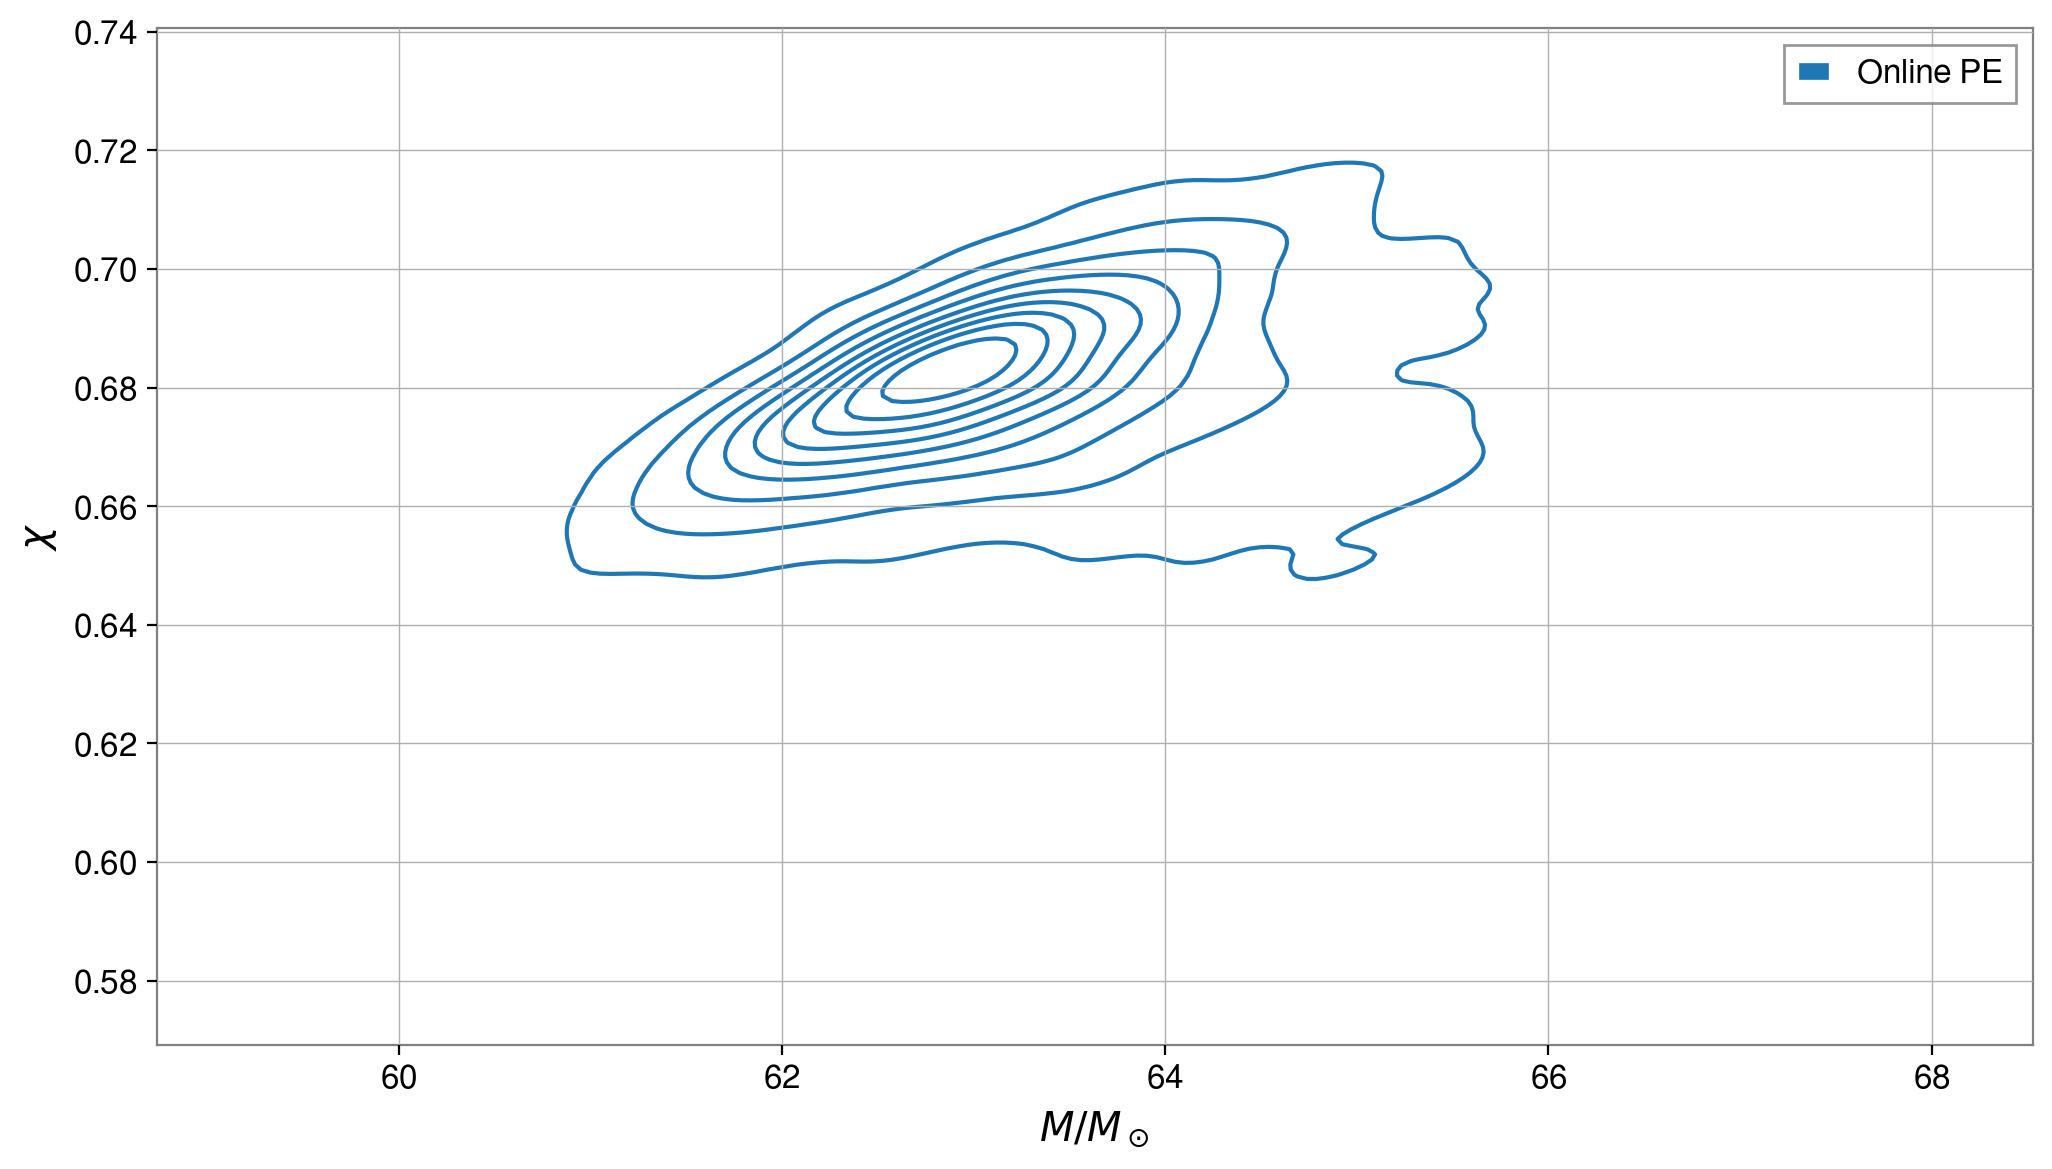

In [29]:
pe = np.genfromtxt('online_pesummary.dat', names=True)
l, = pl.plot([], [], label='Online PE')
sns.kdeplot(x=pe['final_mass'], y=pe['final_spin'], color=l.get_color())
pl.xlabel(r'$M / M_\odot$')
pl.ylabel(r'$\chi$')
pl.legend()

In [30]:
pe_fs = {}
pe_gammas = {}
with tqdm(total=28) as pbar:
    for l in [2,3]:
        for m in range(0, l+1):
            for n in [0,1,2,3]:
                fs = []
                gammas = []
                for s in pe:
                    f,t = rd.qnms.get_ftau(s['final_mass'], s['final_spin'], l=l, m=m, n=n)
                    fs.append(f)
                    gammas.append(1/t)
                pe_fs[(l,m,n)] = np.array(fs)
                pe_gammas[(l,m,n)] = np.array(gammas)

                pbar.update(1)

  0%|          | 0/28 [00:00<?, ?it/s]

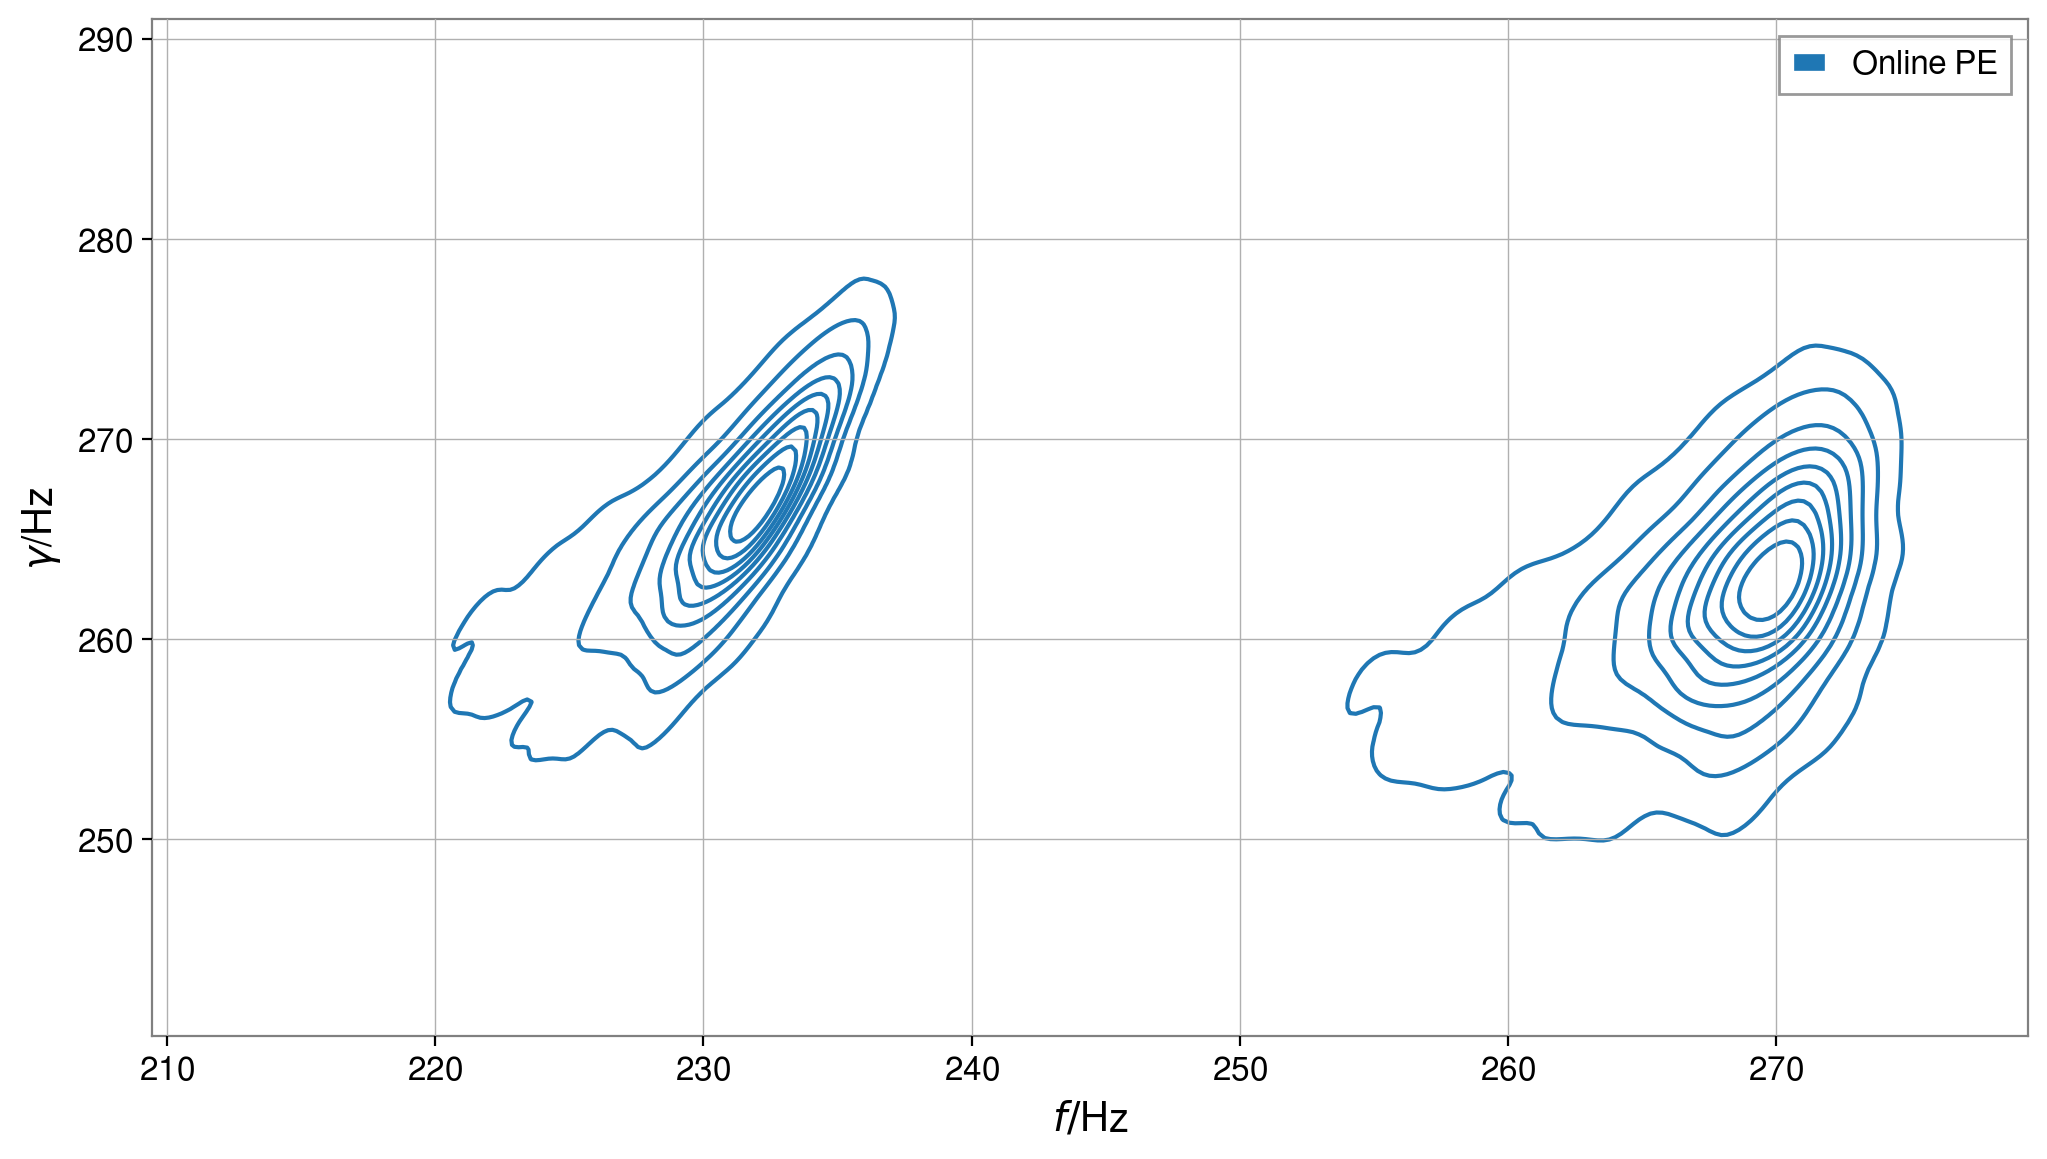

In [31]:
l, = pl.plot([], [], label='Online PE')
sns.kdeplot(x=pe_fs[(2,2,0)], y=pe_gammas[(2,2,0)], color=l.get_color())
sns.kdeplot(x=pe_fs[(2,1,0)], y=pe_gammas[(2,1,0)], color=l.get_color())
pl.xlabel(r'$f/$Hz')
pl.ylabel(r'$\gamma$/Hz')
pl.legend()

In [32]:
data = TimeSeries.read('L-L1_G429267_llhoft-1376089749.0-14.gwf', 'L1:GDS-CALIB_STRAIN_CLEAN')
times_list = [float(i/u.s) for i in data.times]
# has 14s of data sampled at 16K

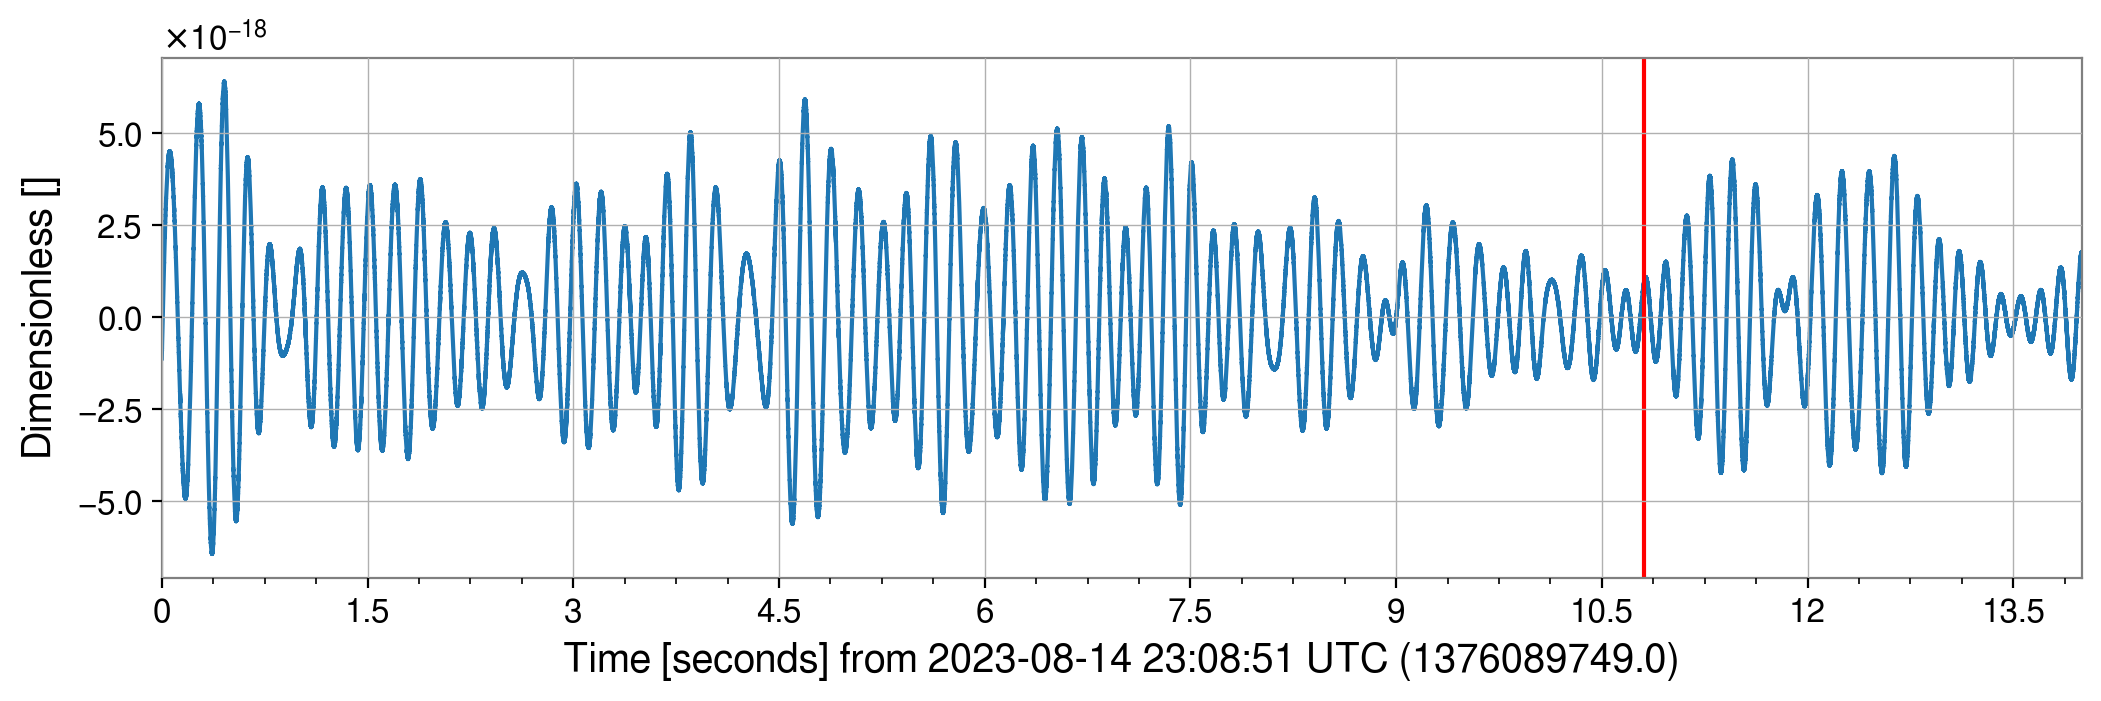

In [33]:
t_ref = 1376089759.81
data.plot()
pl.axvline(t_ref, c = 'r')

(1e-24, 1e-19)

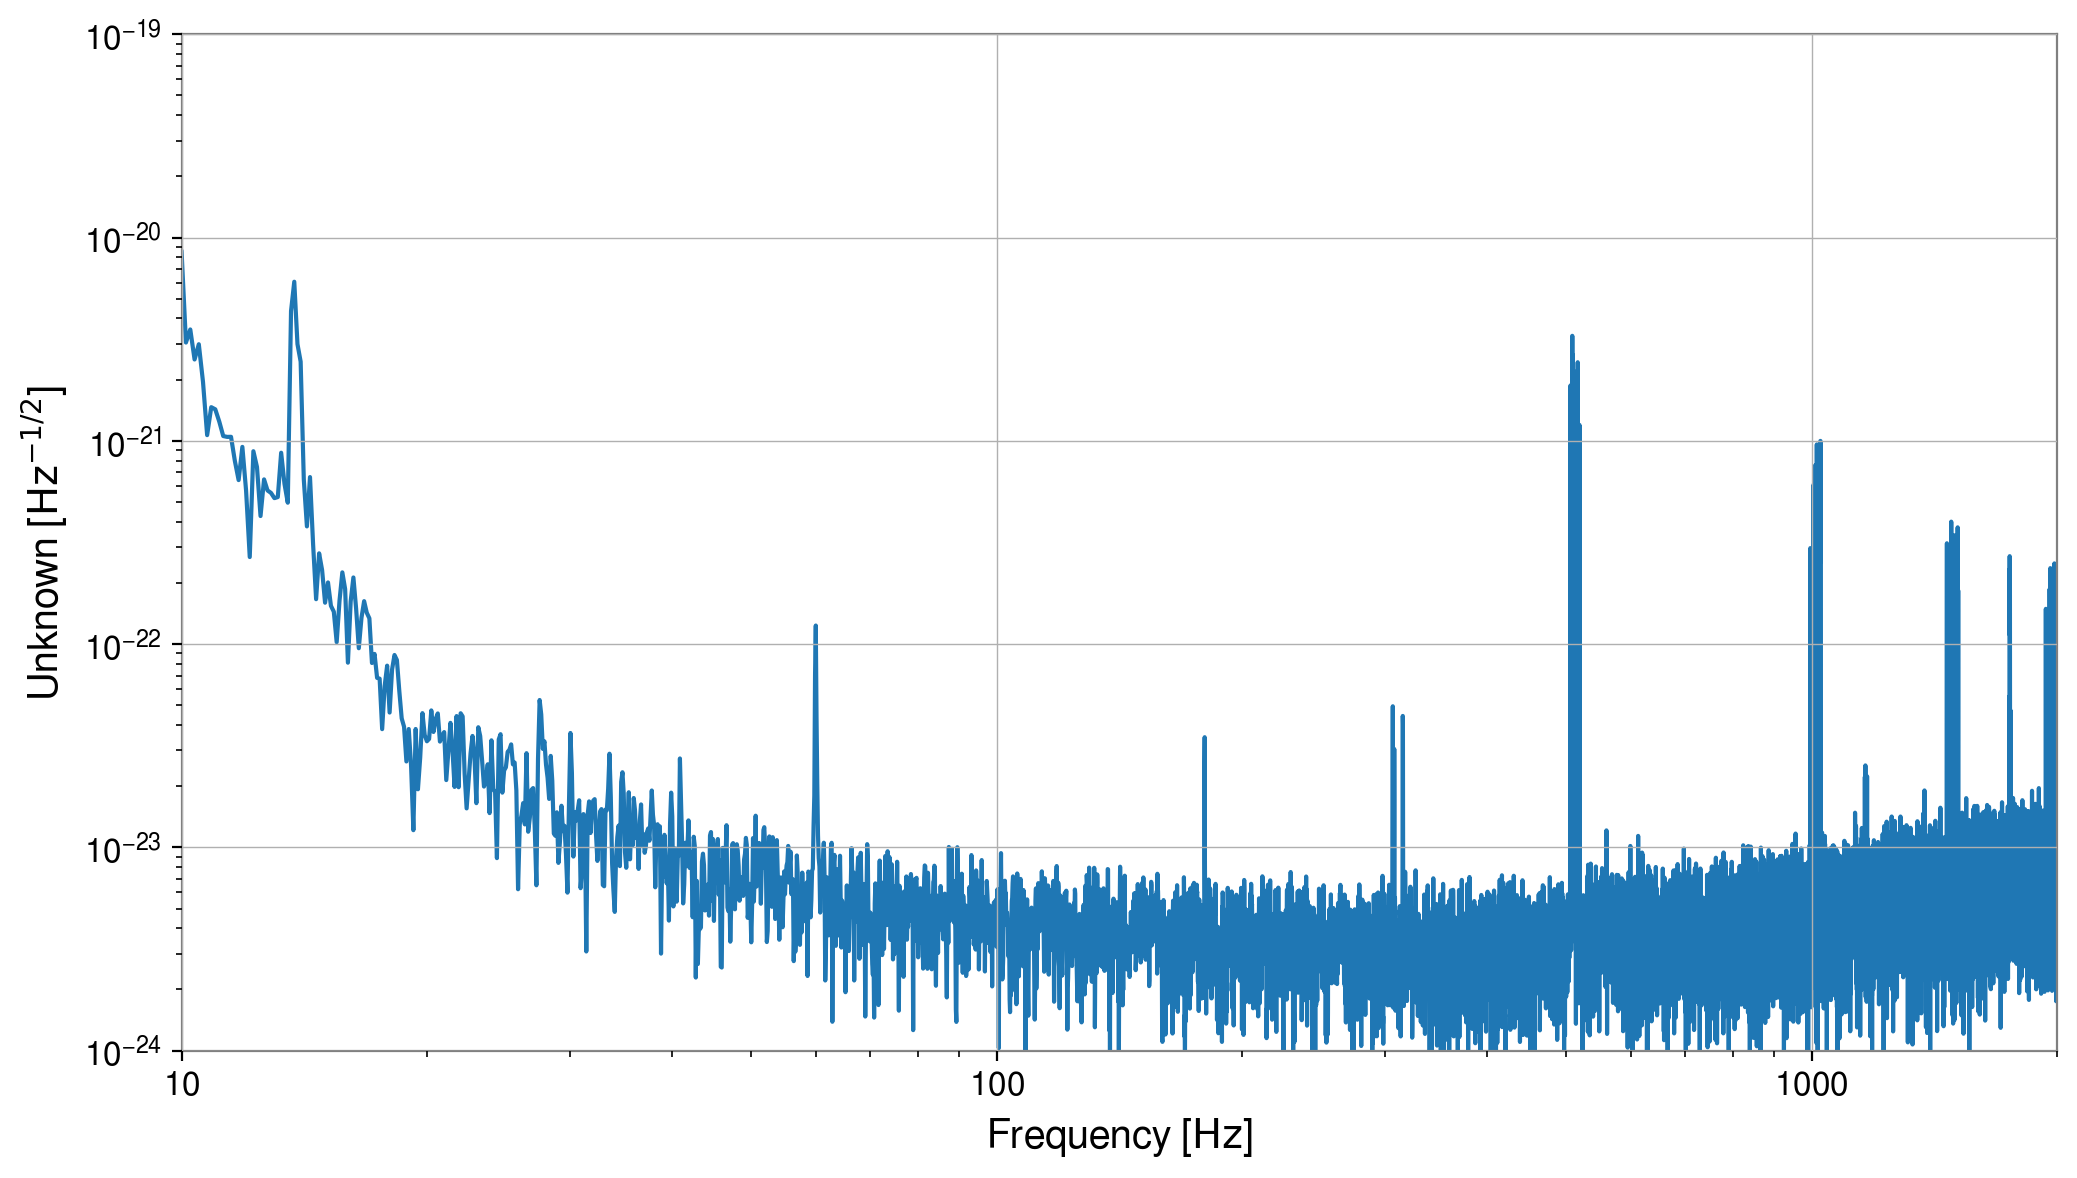

In [34]:
data.asd(fftlength = 8).plot()
pl.xlim(10,2000)
pl.ylim(1e-24, 1e-19)

(1376089759.61, 1376089759.9099998)

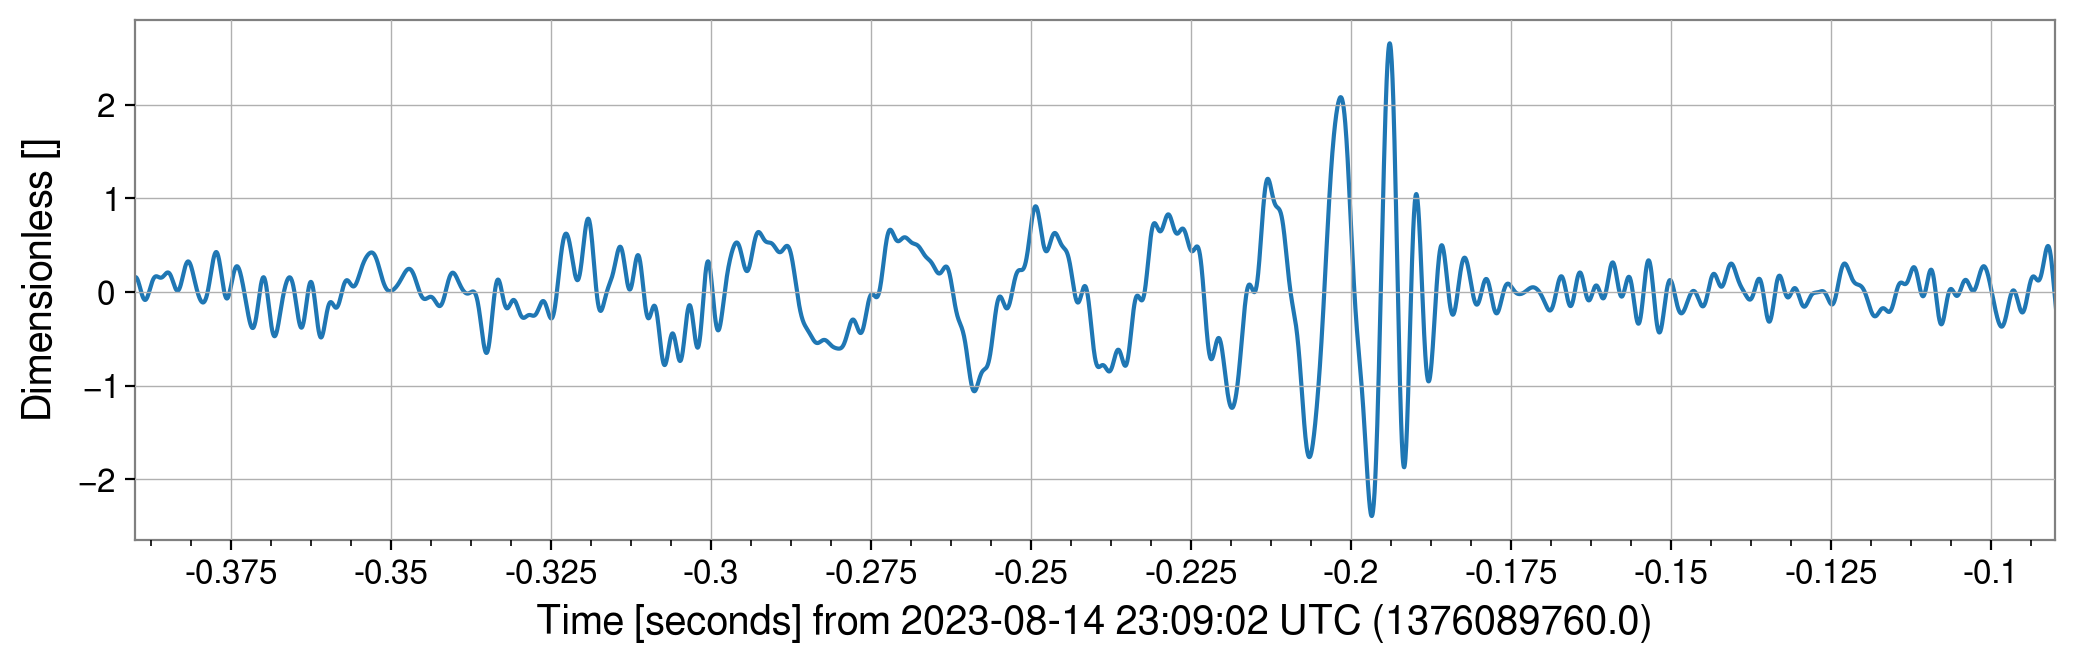

In [35]:
# -- Whiten and bandpass data
white_data = data.whiten()
bp_data = white_data.bandpass(30, 400)
fig3 = bp_data.plot()
pl.xlim(t_ref-0.2, t_ref+0.1)

In [36]:
t_0 = float(bp_data.times[np.argmax(bp_data.value)]/u.s)

In [37]:
t_0

1376089759.8060913

Download data

Set some parameters of GW150914

In [53]:
t_0

1376089759.8060913

In [162]:
IMR = [63.06, 0.68]
mass_unit = qnm_filter.Filter.mass_unit(IMR[0]) 
time_offset = 0 # in units of mass

input = dict(model_list = [(2, 2, 0, 'p')], #l, m, n, prograde/retrograde
             # trucation time (geocenter, in second)
             t_init = t_0+time_offset*mass_unit, #event time from https://gracedb.ligo.org/superevents/S230814ah/view/
             # length of the analysis segment (in second)
             segment_length = 0.4,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = None, dec = None,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)
output_str = ''
for item in input['model_list']:
    output_str += f"{item[0]}{item[1]}{item[2]}+"
filter_str = output_str.rstrip('+')

fit = qnm_filter.Network(**input)

Load data

In [163]:
fit.original_data['L1'] = qnm_filter.RealData(data.value, index = times_list)

Perform time alignment across detectors

In [164]:
fit.detector_alignment()

Condition data 

In [165]:
fit.condition_data('original_data', trim = 0.05, **input)

Cholesky-decomposition of the covariance matrix 

In [166]:
fit.compute_acfs('original_data')
fit.cholesky_decomposition()

## Likelihood as a function of mass and spin

Sampling remnant mass and spin

In [167]:
delta_mass = 0.2
delta_chi = 0.005
massspace = np.arange(30, 100, delta_mass)
chispace = np.arange(0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

Interate over the samplings

In [168]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
credible_region10 = qnm_filter.find_credible_region(likelihood_data, target_probability=0.1)
credible_region50 = qnm_filter.find_credible_region(likelihood_data, target_probability=0.5)

In [169]:
IMR_analysis = [63.06, 0.68, [[1.23], [1.8]], [[0.02], [0.02]]]

Text(0.5, 1.0, 'S230814 \n $t_{init}$ + 0$M_\\odot$, filters = 220\n segment_width = 0.4s')

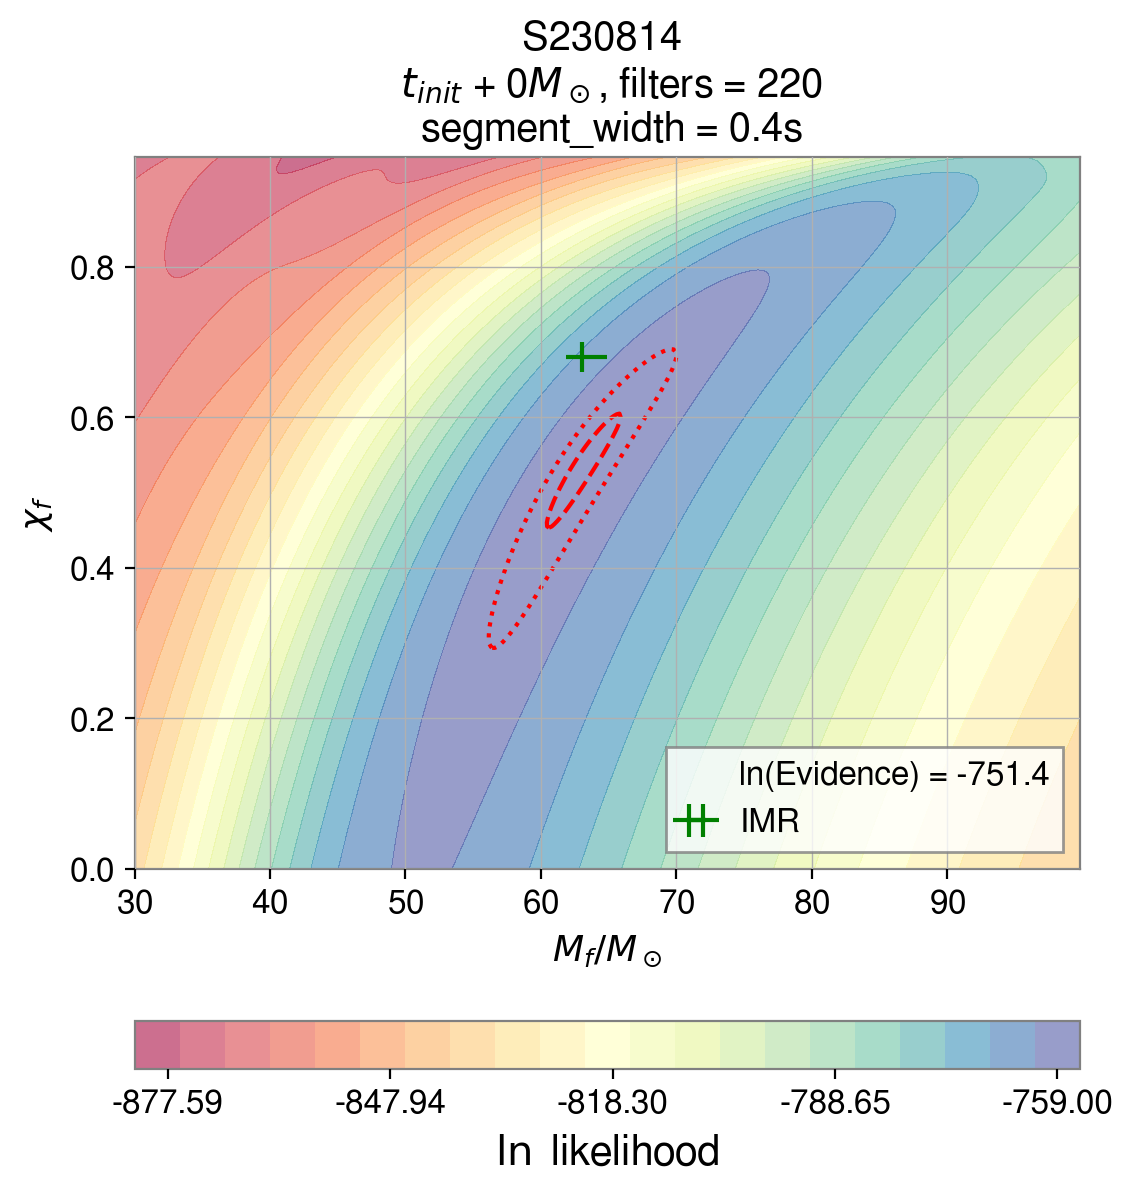

In [176]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted10 = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region10], colors = 'red', \
                   linestyles ='--')
dotted50 = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region50], colors = 'red', \
                   linestyles =':')
ax.errorbar(x=IMR_analysis[0], y=IMR_analysis[1], xerr=IMR_analysis[2], yerr=IMR_analysis[3], 
           c='g', label='IMR')
ax.plot(np.NaN, np.NaN, '-', color='none', label='ln(Evidence) = %.1F' % evidence)


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend(loc = 'lower right')

ax.set_title('S230814 \n $t_{init}$ + ' + str(time_offset) +
             r'$M_\odot$, filters = ' + filter_str + '\n segment_width = 0.4s')
# pl.savefig('./gif_imgs/220+1_t={}M.png'.format(time_offset))

In [171]:
0.2*1/rd.qnms.get_ftau(IMR_analysis[0], IMR_analysis[1], l=2,m=2,n=0)[1]

52.48695390091548

In [172]:
## results = []
levels = [dotted10, dotted50]
for i in levels:
    temp0 = []
    for j in i.collections[0].get_paths():
        coords = j.vertices
        temp1 = [(rd.qnms.get_ftau(k[0], k[1], l=2,m=2,n=0),
               rd.qnms.get_ftau(k[0], k[1], l=2,m=2,n=1),
               rd.qnms.get_ftau(k[0], k[1], l=2,m=1,n=0),
               rd.qnms.get_ftau(k[0], k[1], l=2,m=2,n=2)) for k in coords]
#         temp1.append(temp1[0])
        temp0.append(temp1)
    results.append(temp0)

/home/neil/anaconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/home/neil/anaconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
/home/neil/anaconda3/envs/ringdown/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(


IndexError: list index out of range

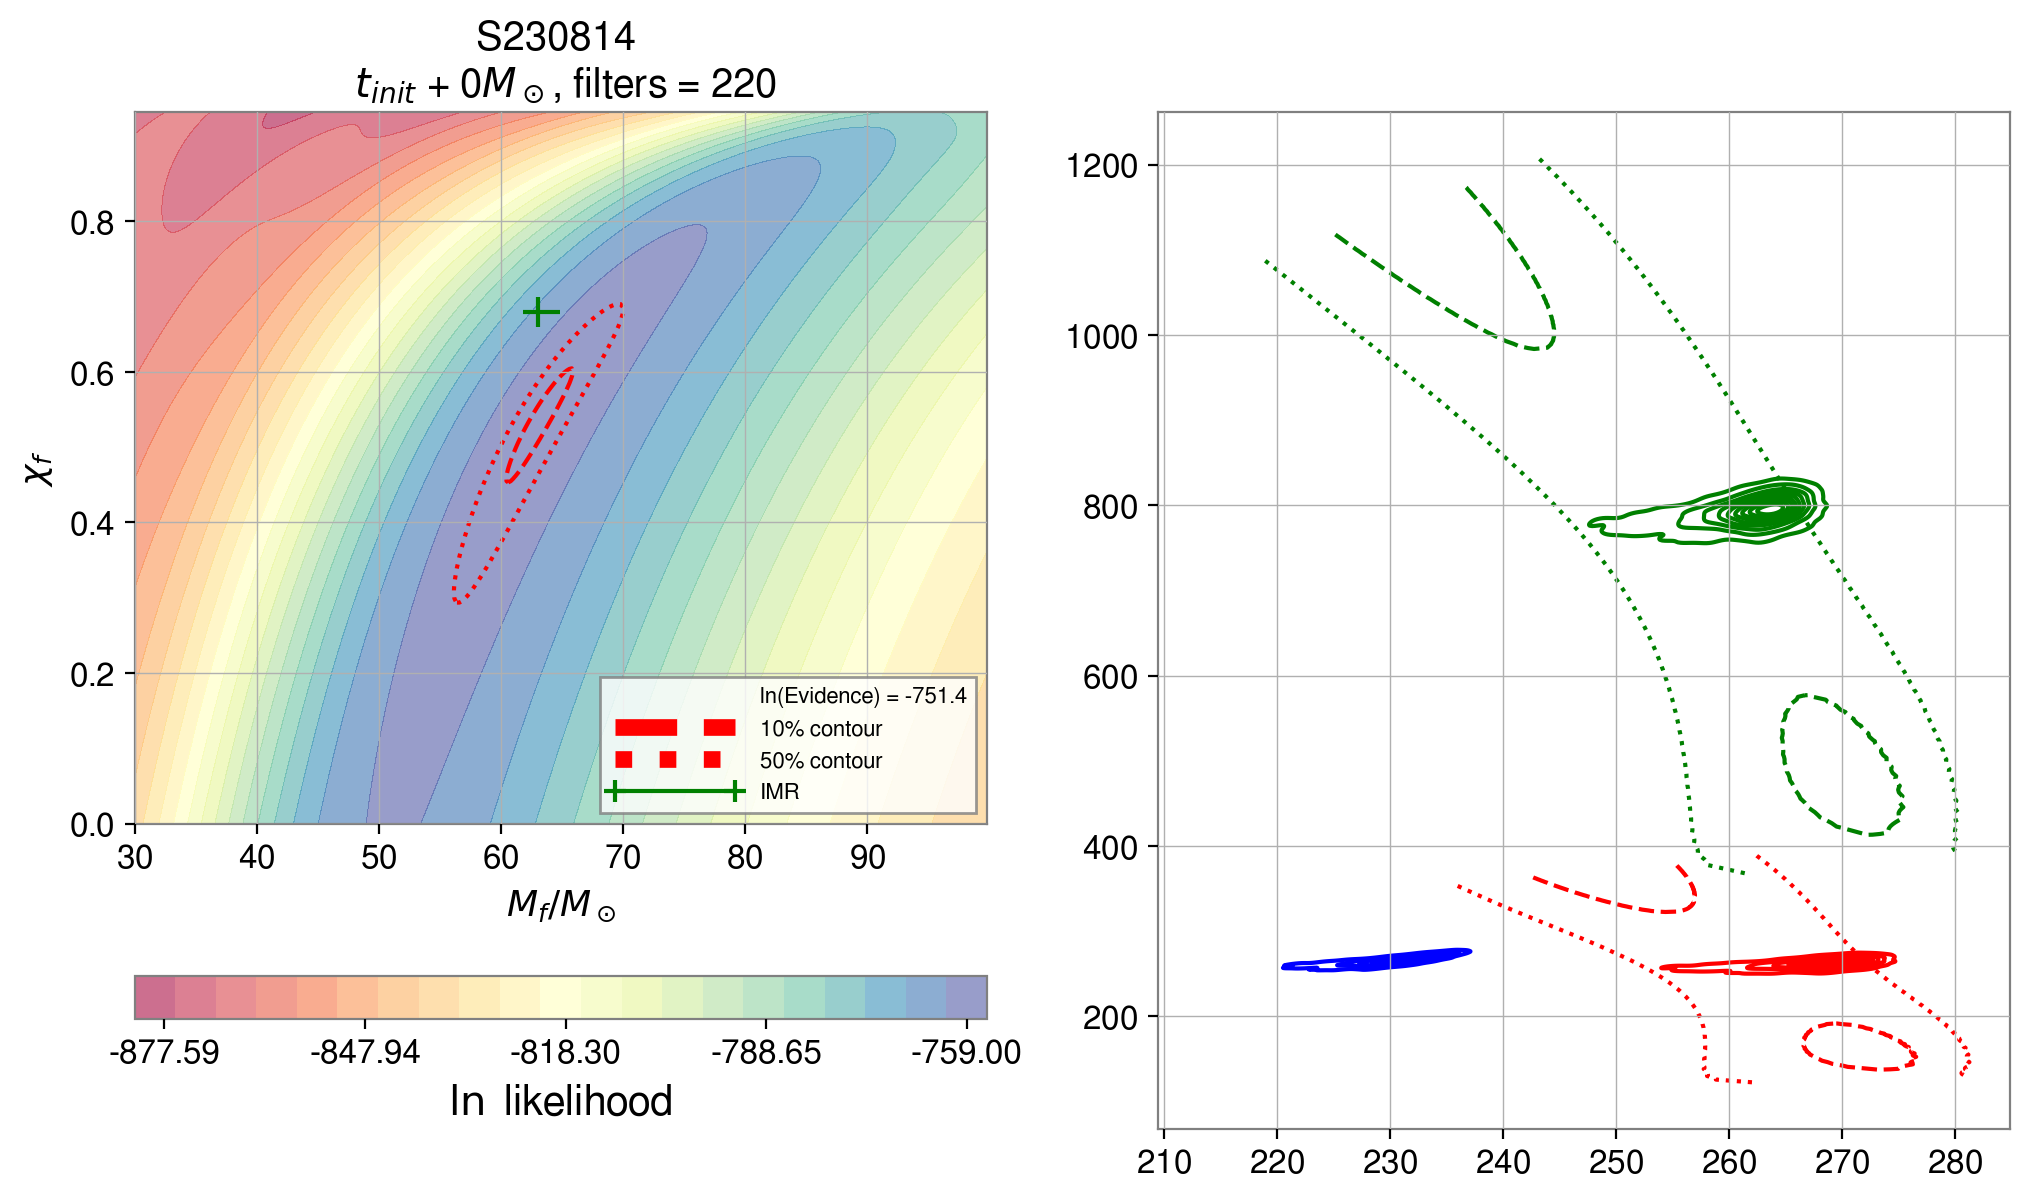

In [173]:
ls_arr = ['--',':']

pl.rc('figure', figsize=(12.1, 6.6))
fig, axs = pl.subplots(1,2)
contours = axs[0].contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted10 = axs[0].contour(mass_grid, chi_grid, likelihood_data, [credible_region10], colors = 'red', \
                   linestyles ='--')
dotted50 = axs[0].contour(mass_grid, chi_grid, likelihood_data, [credible_region50], colors = 'red', \
                   linestyles =':')
axs[0].errorbar(x=IMR_analysis[0], y=IMR_analysis[1], xerr=IMR_analysis[2], yerr=IMR_analysis[3], 
           c='g', label='IMR')
axs[0].plot(np.NaN, np.NaN, '-', color='none', label='ln(Evidence) = %.1F' % evidence)
axs[0].plot([], [], c='r', ls = '--', lw = 0.01, ms=0.01, label='10% contour')
axs[0].plot([], [], c='r', ls = ':', label='50% contour')

# colorbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

axs[0].set_xlabel(r'$M_f/M_\odot$', fontsize=13)
axs[0].set_ylabel(r'$\chi_f$', fontsize=13)
axs[0].legend(loc = 'lower right', fontsize=8, handlelength=6)

axs[0].set_title('S230814 \n $t_{init}$ + ' + str(time_offset) +
             r'$M_\odot$, filters = ' + filter_str)
# pl.savefig('./gif_imgs/220+1_t={}M.png'.format(time_offset))

sns.kdeplot(x=pe_fs[(2,2,0)], y=pe_gammas[(2,2,0)], c='r', ax=axs[1])
sns.kdeplot(x=pe_fs[(2,1,0)], y=pe_gammas[(2,1,0)], c='blue', ax=axs[1])
sns.kdeplot(x=pe_fs[(2,2,1)], y=pe_gammas[(2,2,1)], c='green', ax=axs[1])
# sns.kdeplot(x=pe_fs[(2,1,0)], y=pe_gammas[(2,1,1)], c='teal', ax=axs[1])
# sns.kdeplot(x=pe_fs[(2,2,2)], y=pe_gammas[(2,2,2)], c='orange', ax=axs[1])
for idx, i in enumerate(results):
    for j in i:
        temp = np.array(j)
        axs[1].plot(temp[:,0,0], 1/temp[:,0,1], c='r', ls=ls_arr[idx])
        axs[1].plot(temp[:,1,0], 1/temp[:,1,1], c='g', ls=ls_arr[idx])
#         axs[1].plot(temp[:,2,0], 1/temp[:,2,1], c='blue', ls=ls_arr[idx])
#         axs[1].plot(temp[:,3,0], 1/temp[:,3,1], c='orange', ls=ls_arr[idx])

l, = pl.plot([], [], c='r', label='220')
l, = pl.plot([], [], c='green', label='221')
l, = pl.plot([], [], c='b', label='210')
# l, = pl.plot([], [], c='teal', label='211')
# l, = pl.plot([], [], c='orange', label='222')
pl.legend(loc = 'upper left')
handles, labels = pl.gca().get_legend_handles_labels()
# l, = pl.plot([], [], c='k', ls = '-', label='IMR')
# l, = pl.plot([], [], c='k', ls = '--', label='10% contour')
# l, = pl.plot([], [], c='k', ls = ':', label='50% contour')
pl.legend(loc='upper left')
axs[1].set_title('Implied $f$ and $\gamma$ from 10% and 50% contours')
pl.xlabel(r'$f/$Hz')
pl.ylabel(r'$\gamma$/Hz')